In [1]:
# import general packages
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
from scipy.optimize import brentq

import h5py
import json
import os
from datetime import datetime

import pde
import phasesep_pyrenoid as ph
from phasesep_pyrenoid.helper_functions import init_from_file, get_waistline_profile_fwhm, dimensionalize_params, get_initial_radius, cmap_exp, cmap_orange, dark_orange, colors, colors_exp, colors_phases, add_scalebar, add_timenote
from phasesep_pyrenoid.solvers_simulations import solve_stokes_flow, run_simulation
from droplets import DiffuseDroplet, Emulsion, SphericalDroplet, image_analysis

radius_micrometer = 1 # [micro meter]
shrinking_time = 10 # [minutes]

with open("./simulation_results/Paper/definite/charact_scales.json", "r") as f:
    charact_scales = json.load(f)
T_char, L_char, P_char = (charact_scales[k] for k in ("T_char", "L_char", "P_char"))

FOLDER_RESULTS = "./simulation_results/Paper/definite/asymmetric"
FOLDER_FIGURES= "./simulation_results/Paper/figures_for_paper/"

# Figure 5D

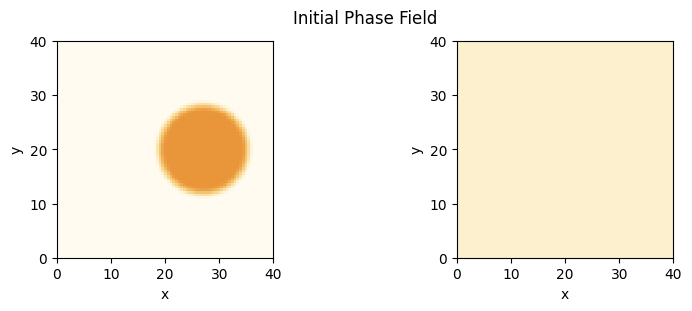

100%|██████████| 100.0/100.0 [00:54<00:00,  1.84it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.71it/s]


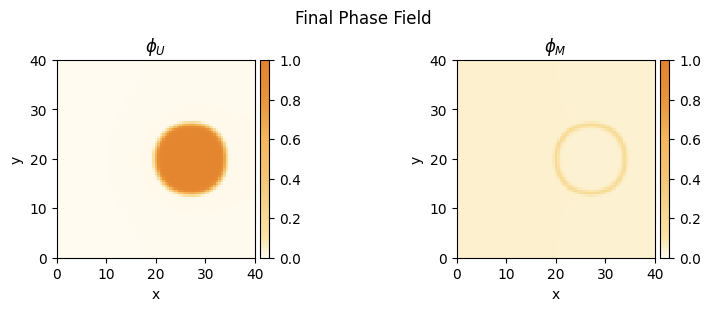

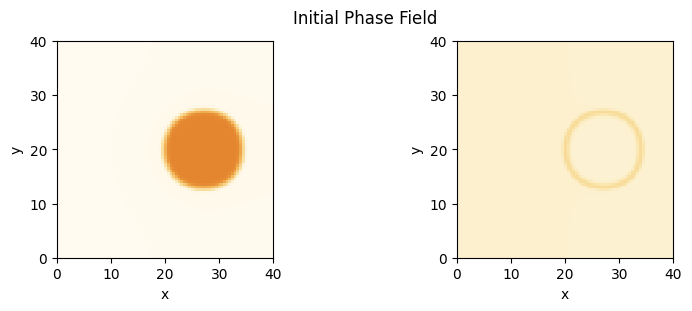

100%|██████████| 100.0/100.0 [00:53<00:00,  1.88it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.04it/s]


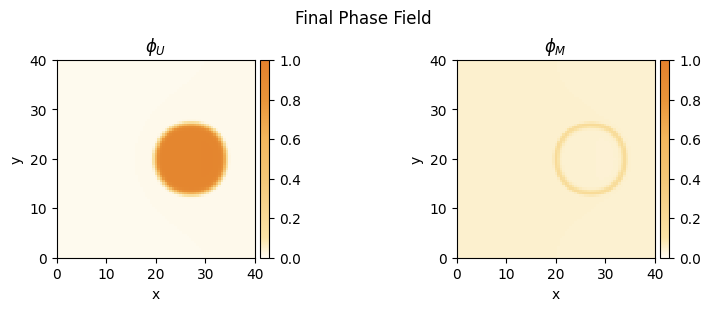

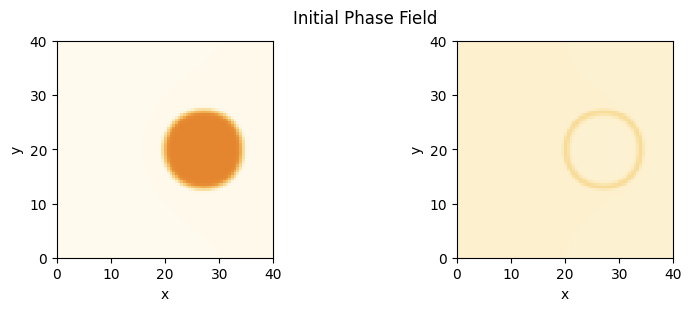

  0%|          | 0/150.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 150.0/150.0 [01:23<00:00,  1.79it/s]    
100%|██████████| 151/151 [00:08<00:00, 17.38it/s]


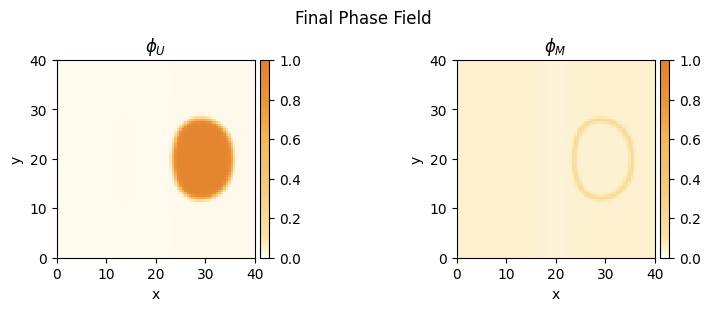

In [ ]:
num_phases = 3
chem_reacts = [False, False, False]
km_reacts = [0, 0.03, 0.03]
chem_reacts_types = ["None", "ext_maint", "ext_maint"]
start_from_input_files = [False, True, True]
advec = [False, False, True]
sim_times = [100,100,150]
input_filename_vec = []

for phase in range(num_phases):
    params_advection = {
        "nx": 83,
        "ny": 83,
        "Lx": 40.0,
        "Ly": 40.0,
        "mu": 40,
        "eta": 12.5,
        "P0": 10,
        "sigma_P": 1.2
    }

    chem_react = chem_reacts[phase]
    params = {
        "k_M": km_reacts[phase] if chem_react else 0,
        "k_U": 0.03 if chem_react else 0,
        "chem_react_type": chem_reacts_types[phase] if chem_react else "None",
        "xc" : 0.5,
        "b" : 200,
        "d" : 1, #9.6 
        "kappa": 1,
        "chi" : 5, # Positive = repulsion
        "shape" : 40,
        "size" : 81,
        "simulation_time" : sim_times[phase],
        "periodic_bc" : False,
        "interval_for_tracking" : 1,
        "advection": advec[phase]
    }

    start_from_input_file = start_from_input_files[phase]
    input_folder = input_filename_vec[phase-1] if start_from_input_file else None
    input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

    # Choose initial conditions for U and M
    selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
    selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

    # Define parameters separately for U and M
    PARAMS_INIT_U = {
        "from_file":{ "filename": input_filename,
            "suffix": "_U.hdf5"
        },
        "random": {
            "phi": 0.5,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [27, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi": 0.5,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 8},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
            ]
        }
    }

    PARAMS_INIT_M = {
            "from_file":{ "filename": input_filename,
            "suffix": "_M.hdf5",
        },
        "random": {
            "phi": 0.05,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [25, 25]  # Relative to shape center
        },
        "emulsion": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 7.5},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
            ]
        }
    }


    save_final_config = True
    ### Save params ###
    if save_final_config:
        run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        output_folder = f"simulation_results/Paper/definite/asymmetric/{run_name}/"
        input_filename_vec.append(output_folder)
        os.makedirs(output_folder, exist_ok=True)

        with open(f"{output_folder}/params.json", "w") as f:
            json.dump(params, f, indent=4)
        if params["advection"]:
            with open(f"{output_folder}/params_advection.json", "w") as f:
                json.dump(params_advection, f, indent=4)
    output_filename = output_folder+f"final_config"

    P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

    sol, solver_info = run_simulation(selected_init_cond_U,
        selected_init_cond_M,
        PARAMS_INIT_U[selected_init_cond_U],
        PARAMS_INIT_M[selected_init_cond_M],
        save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


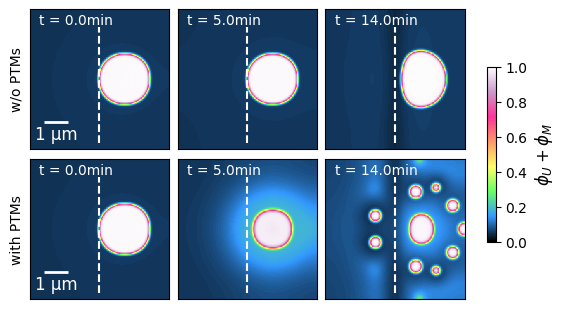

In [2]:
# Load data
storage_read_noPTMs0 = pde.FileStorage(FOLDER_RESULTS+"/2025-09-29_14-45-59/final_config.hdf")
storage_read_noPTMs1 = pde.FileStorage(FOLDER_RESULTS+"/2025-09-29_14-46-58/final_config.hdf")
times = [0, 50, 40]

# Set up figure and axes
fig, axs = plt.subplots(2, 3, figsize=(5.5, 3), constrained_layout=True)

# Plot each time point
for i, time in enumerate(times):
    if time == 0 or time == 50:
        UM_fields = storage_read_noPTMs0[time]
    else:
        UM_fields = storage_read_noPTMs1[time]
    data = np.transpose(UM_fields.data[0]+UM_fields.data[1])
    im = axs[0,i].imshow(data, cmap=cmap_exp, vmin=0, vmax=1, origin="lower")
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[0,i].vlines(40, 3,70, linestyle = "--", color ="white")
    if time == 0 or time == 50:
        add_timenote(axs[0,i], time*T_char, color = "white")
    else:
        add_timenote(axs[0,i], (time+100)*T_char, color = "white")
axs[0,0].set_ylabel('w/o PTMs',fontsize=10)
axs[1,0].set_ylabel('with PTMs',fontsize=10)
with open(FOLDER_RESULTS+"/2025-09-29_14-46-58/params.json", "r") as f:
    params = json.load(f)
dx = params["shape"] / (params["size"]-1)
add_scalebar(axs[0,0], scalebar_y = 15, scalebar_length= 1/(L_char*dx), color = "white")

times = [0, 50, 40]
# Load data
storage_read_PTMs0 = pde.FileStorage(FOLDER_RESULTS+"/2025-09-29_14-40-22/final_config.hdf") 
storage_read_PTMs1 = pde.FileStorage(FOLDER_RESULTS+"/2025-09-29_14-41-19/final_config.hdf")
# Plot each time point
for i, time in enumerate(times):
    if time == 0 or time == 50:
        UM_fields = storage_read_PTMs0[time]
    else:
        UM_fields = storage_read_PTMs1[time]
    data = np.transpose(UM_fields.data[0]+UM_fields.data[1])
    im = axs[1,i].imshow(data, cmap=cmap_exp, vmin=0, vmax=1, origin="lower")
    axs[1,i].vlines(40, 3,70, linestyle = "--", color ="white")
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    if time == 0 or time == 50:
        add_timenote(axs[1,i], time*T_char, color = "white")
    else:
        add_timenote(axs[1,i], (time+100)*T_char, color = "white")

    
add_scalebar(axs[1,0], scalebar_y = 15, scalebar_length= 1/(L_char*dx), color = "white")

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, orientation='vertical')
cbar.set_label(r"$\phi_U+\phi_M$", fontsize=12)
plt.savefig(FOLDER_FIGURES+"asym_PTMs_no_PTMs_snapshots.svg")
plt.show()